# Prototyping an automatic well tie

## Outline

1. Building a Synthetic Well Log
1. Generating Synthetic Seismic trace
1. Generating Synthetic using portion of Synthetic Well
1. Dynamic Time Warping (DTW) for automatic well ties

This notebook will explore building a synthetic well log of alternating lithology units, namely shale and sand.

The synthetic well log will be convolved with a wavetlet and then will have random noise added.  This will be our synthetic seismic trace.

The we will then use only a portion of the synthetic well to simulate the portion recorded by wireline logging.  This will be used to create a synthetic for seismic-to-well tie purposes.

We will then explore using dtw-python to create an automatic well tie.

A portion of code from a 2017 SEG Tutorial on [Seismic Rock Physics](https://github.com/seg/tutorials-2017/blob/master/1706_Seismic_rock_physics/seismic_rock_physics.ipynb) will help guide some of the work to build a synthetic well.

## Library Imports

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

rng = np.random.RandomState(seed=42)

from bruges.filters import ricker
from bruges.reflection import shuey2

## Roadmap

Let's lay out the roadmap for this project:

1. Create the synthetic sample of the earth:
    - Generate a random sequence of 0's and 1's where 0 represents shale and 1 represents sand.
    - Assign rock properties (Vp, Vs, Rhob) for shale and sand lithology


2. Build an impedance model from the synthetic sample of the earth.

1. Make a subsample of the synthetic sample to use as the wireline log and create a synthetic


## 1. Create the synthetic sample of the earth

Begin by creating a random sequence of 0's and 1's of n samples to represent alternating lithologic layers

In [62]:
n_samples = 2000
#lith_sequence = rng.randint(low=0, high=2, size=n_samples)
lith_sequence = rng.choice([0,1], size=n_samples, p=[0.75,0.25]) # bias the random choice towards 0 (shale)

In [63]:
lith_sequence

array([0, 1, 1, ..., 0, 1, 1])

Make a plot of lith_sequence colored by the value of lith_sequence

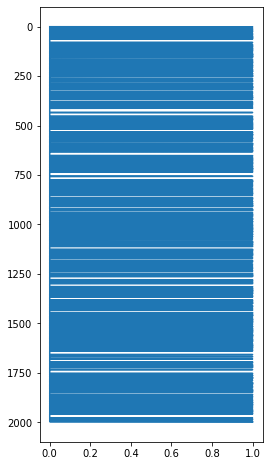

In [64]:
fig = plt.figure(figsize=(4,8))

ax = fig.add_subplot(1,1,1)
ax.plot(lith_sequence, range(0,n_samples))
ax.invert_yaxis()

plt.show()

This is pretty difficult to see what is going on... Zoom in on the first 100 samples

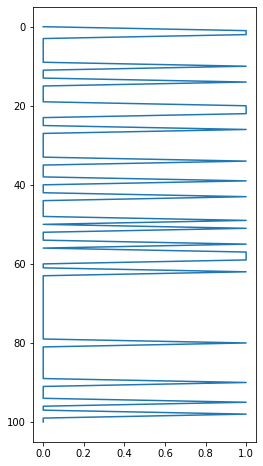

In [65]:
fig = plt.figure(figsize=(4,8))
ax = fig.add_subplot(1,1,1)
ax.plot(lith_sequence[0:101], range(0,101))
ax.invert_yaxis()
plt.show()

This looks promising.  However, To make a meaningful display of it using imshow, we need to duplicate the rows

In [70]:
lith = np.array([lith_sequence]*100)

In [71]:
lith

array([[0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       ...,
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 1]])

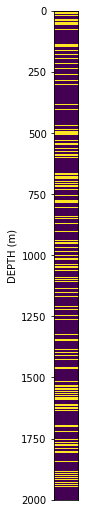

In [72]:
fig = plt.figure(figsize=(4,9))
ax = fig.add_subplot(1,1,1, xticks=(), xticklabels=())
ax.imshow(lith.T)
ax.set_ylabel('DEPTH (m)')
ax.set_ylim(0,2000)
ax.invert_yaxis()
plt.show()

Ok, now we have a synthetic model that looks a plausible representation of the subsurface.

Now, let's define Vp, Vs, & Rhob for Shale (0) and Sand (1)

In [69]:
Vp_sd = 3032
Vs_sd = 1543
Rhob_sd = 2.17

Vp_sh = 2430
Vs_sh = 919
Rhob_sh = 2.11

In [80]:
AI_sd = Vp_sd * Rhob_sd
SI_sd = Vs_sd * Rhob_sd

AI_sh = Vp_sh * Rhob_sh
SI_sh = Vs_sh * Rhob_sh